In [17]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
metadata_df = pd.read_csv("train_metadata.csv", index_col="sample")
data_df = pd.read_csv("train_data.csv",  index_col="sample")

In [3]:
metadata_df.columns

Index(['baboon_id', 'collection_date', 'sex', 'age', 'social_group',
       'group_size', 'rain_month_mm', 'season', 'hydro_year', 'month',
       'diet_PC1', 'diet_PC2', 'diet_PC3', 'diet_PC4', 'diet_PC5', 'diet_PC6',
       'diet_PC7', 'diet_PC8', 'diet_PC9', 'diet_PC10', 'diet_PC11',
       'diet_PC12', 'diet_PC13'],
      dtype='object')

full correlation between moth and season - no need to take both
6-10 - wet else dry.



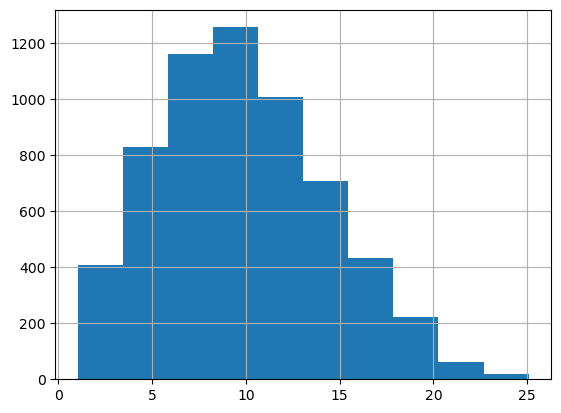

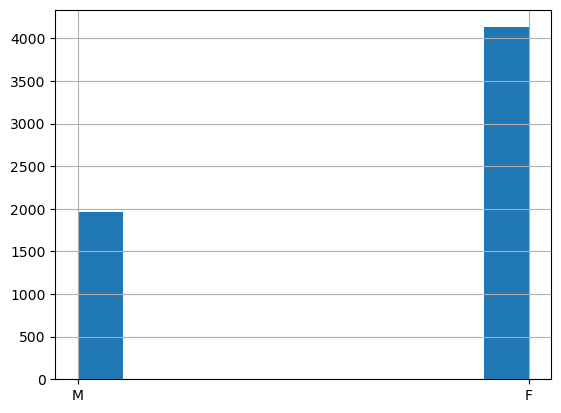

In [4]:
metadata_df["age"].hist()

plt.show()
metadata_df["sex"].hist()

plt.show()


In [5]:
metadata_df_M = metadata_df[metadata_df["sex"]=="M"]
metadata_df_F = metadata_df[metadata_df["sex"]=="F"]

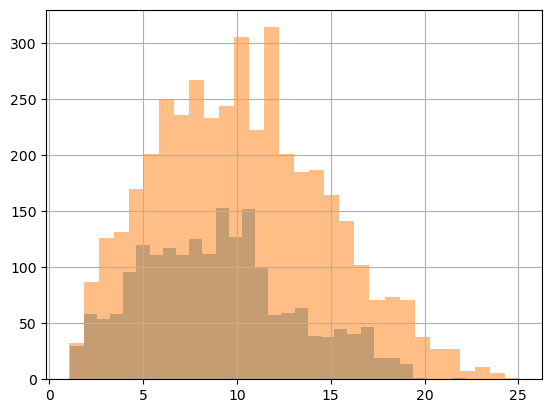

In [6]:
metadata_df_M["age"].hist(bins = 30, alpha=0.5)

metadata_df_F["age"].hist(bins=30, alpha=0.5)

plt.show()

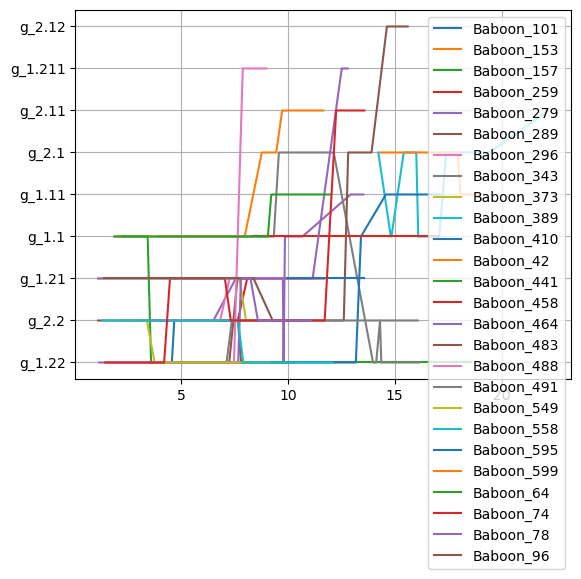

In [7]:
for baboon in metadata_df_M["baboon_id"].unique():
    age = metadata_df_M["age"][metadata_df_M["baboon_id"] == baboon]
    social_group = metadata_df_M["social_group"][metadata_df_M["baboon_id"] == baboon]
    plt.plot(age, social_group, label=baboon)
    
plt.grid()
plt.legend()
plt.show()

In [8]:
# make sure the data is sorted by sample date
metadata_df_M.sort_values(by=["baboon_id","collection_date"], inplace=True)


C:\Users\yuvald\AppData\Local\Temp\ipykernel_37932\3969196945.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df_M.sort_values(by=["baboon_id","collection_date"], inplace=True)


In [9]:
# for each baboon - summig  up the number of social group change over the years.
number_of_group_change_M = []
for baboon in metadata_df_M["baboon_id"].unique():
    baboon_df = pd.DataFrame({"social_group":metadata_df_M["social_group"][metadata_df_M["baboon_id"]==baboon]})
    baboon_df["next_social_group"] = baboon_df["social_group"].shift(1)
    group_change = (baboon_df["next_social_group"] != baboon_df["social_group"]).astype('int')
    number_of_group_change_M.append(np.sum(group_change)-1)
    
number_of_group_change_F = []
for baboon in metadata_df_F["baboon_id"].unique():
    baboon_df = pd.DataFrame({"social_group":metadata_df_F["social_group"][metadata_df_F["baboon_id"]==baboon]})
    baboon_df["next_social_group"] = baboon_df["social_group"].shift(1)
    group_change = (baboon_df["next_social_group"] != baboon_df["social_group"]).astype('int')
    number_of_group_change_F.append(np.sum(group_change)-1)



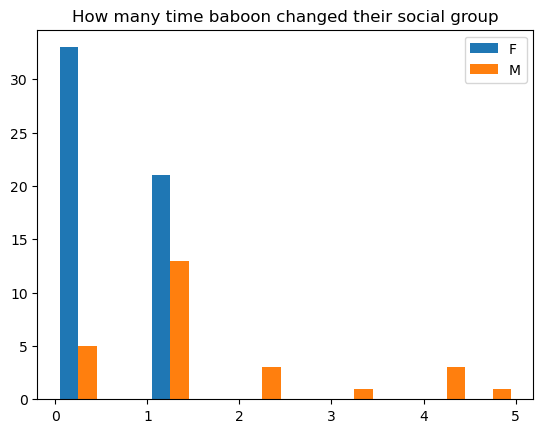

In [10]:
plt.hist([number_of_group_change_F,number_of_group_change_M], label=["F","M"])
plt.legend()
plt.title("How many time baboon changed their social group")
plt.show()

In [11]:
np.mean(metadata_df.groupby("baboon_id")["collection_date"].count())

76.2

1. clustering baboons by averege microbiome profile.
2. changes samples throughout time for each baboon.

In [12]:
# add baboon_id column
data_df["baboon_id"] = metadata_df["baboon_id"]

data_df_avg = data_df.groupby("baboon_id").mean()

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:36<00:00,  4.57s/it]


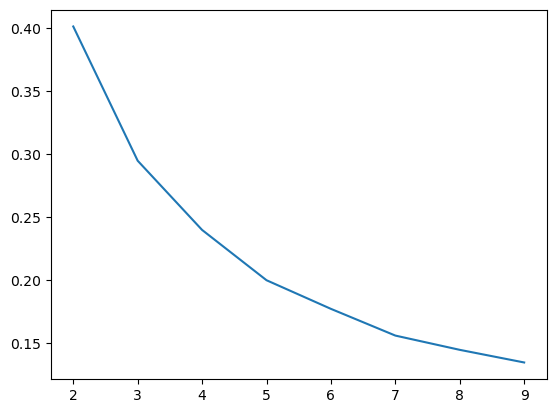

In [18]:
import os
os.environ["OMP_NUM_THREADS"] = '1'
from sklearn.cluster import KMeans


distortions = []
for k in tqdm(range(2, 10)):
    val = 0
    for _ in range(10):
        kmeans = KMeans(n_clusters=k, n_init=10)
        kmeans.fit(data_df_avg.values)
        val += kmeans.inertia_
    
    distortions.append(val/10)
plt.plot(range(2,10),distortions)



In [45]:
kmean = KMeans(n_clusters=7, n_init=10)
labels = kmean.fit(data_df_avg.values).labels_

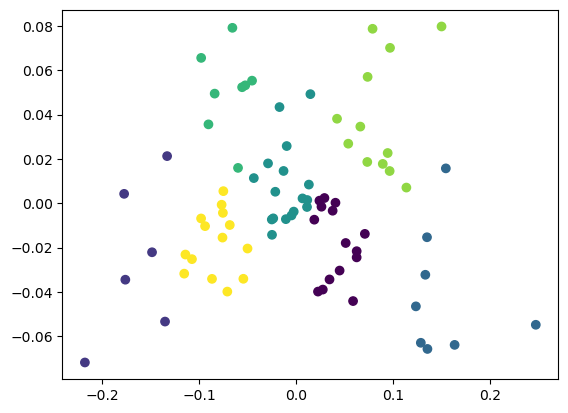

In [46]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
results = pca.fit_transform(data_df_avg).transpose()

plt.scatter(results[0], results[1], c=labels)
plt.show()